# Evaluate water mass properties on the Amundsen Shelf using Pierre's observations

In [68]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import region_bounds, region_names
from nemo_python_git.file_io   import read_dutrieux
from nemo_python_git.utils     import convert_to_teos10
from nemo_python_git.plots     import finished_plot

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
run_folder    = f'{base_dir}output/ERA5_test4_cont/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20240305.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20240305.nc'

In [3]:
nemo_mesh_ds  = xr.open_dataset(nemo_mesh).isel(time_counter=0)
nemo_mesh_sub = nemo_mesh_ds.isel(x=slice(580, 790), y=slice(200,300))

bathy = xr.where((nemo_mesh_sub.isfdraft > 0) | (nemo_mesh_sub.bathy_metry==0), np.nan, nemo_mesh_sub.bathy_metry)

### Look at variability of profiles in different regions of the Amundsen Sea

regions:
- PITW trough
- Dotson front
- Pine Island Bay
- Shelfbreak

In [4]:
gridT_files  = glob.glob(f'{run_folder}/*grid_T*')
nemo_ds      = xr.open_dataset(gridT_files[-10]).isel(time_counter=0) # load all thegridT files in the run folder
# nemo_ds = xr.open_mfdataset(gridT_files, engine='netcdf4')
nemo_ds      = nemo_ds.rename({'x_grid_T':'x', 'y_grid_T':'y', 'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'deptht':'depth'}) 
nemo_results = nemo_ds #nemo_ds.isel(time_counter=slice(180,None)).mean(dim='time_counter')  # Average time series
    
# load observations:
obs          = read_dutrieux(eos='teos10')
dutrieux_obs = obs.assign({'nav_lon':obs.lon, 'nav_lat':obs.lat}).rename_dims({'lat':'y', 'lon':'x'})

In [59]:
regions = ['amundsen_west_shelf_break', 'pine_island_bay', 'dotson_bay']
region_zlim = [1500, 1000, 100]
r = 0

In [56]:
def region_sims_profile(region, variable, nemo_results, nemo_mesh_ds):
    
    [xmin, xmax, ymin, ymax] = region_bounds[region]
    mask_region      = (nemo_results.nav_lon >= xmin)*(nemo_results.nav_lon <= xmax)*(nemo_results.nav_lat >= ymin)*(nemo_results.nav_lat <= ymax)
    nemo_land_mask   = nemo_mesh_ds.tmask.rename({'nav_lev':'depth'})
    
    variable_region  = xr.where(mask_region*(nemo_land_mask==1), nemo_results[variable], np.nan)
    dA_region        = xr.where(mask_region*(nemo_land_mask==1), nemo_results.area_grid_T, np.nan)

    variable_profile = (variable_region*dA_region).sum(dim=['x','y'])/dA_region.sum(dim=['x','y'])
    
    return variable_profile

In [57]:
sims_T = region_sims_profile(regions[r], 'thetao', nemo_results, nemo_mesh_ds)
sims_S = region_sims_profile(regions[r], 'so', nemo_results, nemo_mesh_ds)

In [53]:
# Make a mask which is 1 only within these bounds where there is data, and excluding cavities
[xmin, xmax, ymin, ymax] = region_bounds[regions[r]]
obs_mask_region          = (dutrieux_obs.nav_lon >= xmin)*(dutrieux_obs.nav_lon <= xmax)*(dutrieux_obs.nav_lat >= ymin)*(dutrieux_obs.nav_lat <= ymax)
obs_region               = xr.where(obs_mask_region , dutrieux_obs.ConsTemp, np.nan)
# obs_profile  = np.sum(obs_region*obs_dA, axis=(1,2))/np.sum(obs_dA, axis=(1,2))

# # Make a smoothed version
# obs_profile_smoothed = moving_average(obs_profile, obs_smooth, keep_edges=True)
# model_profile_smoothed = moving_average(model_profile, obs_smooth, keep_edges=True)
# index = obs_depth < obs_smooth_below
# obs_profile[index] = obs_profile_smoothed[index]
# model_profile[index] = model_profile_smoothed[index]                

# # Calculate time-mean and standard deviation from each source
# model_mean      = np.mean(model_data, axis=-2)
# model_std       = np.std(model_data, axis=-2)

Text(0, 0.5, 'Depth (m)')

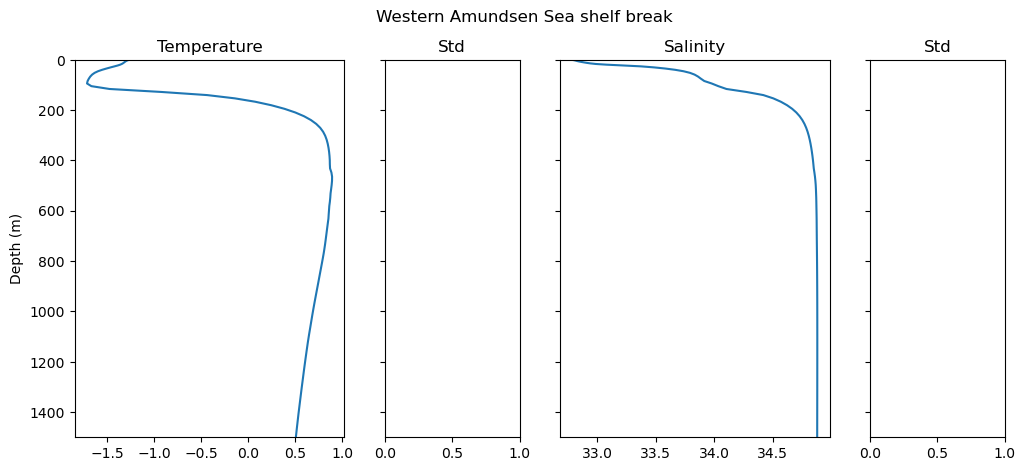

In [70]:
fig, ax = plt.subplots(1,4, figsize=(12,5),  gridspec_kw={'width_ratios':[2,1,2,1]}, dpi=100)
fig.suptitle(region_names[regions[r]])

titles = ['Temperature', 'Std', 'Salinity', 'Std']
for n, axis in enumerate(ax.ravel()):
    ax[n].set_title(titles[n])
    ax[n].set_ylim(region_zlim[r], 0)
    if n!=0: ax[n].yaxis.set_ticklabels([])

ax[0].plot(sims_T, sims_T.depth, label='Model')
ax[2].plot(sims_S, sims_S.depth)

ax[0].set_ylabel('Depth (m)')

In [ ]:
# Make a 3x2 plot showing temperature and salinity casts in 3 regions, comparing ERA5-forced output to Pierre's climatology.
def plot_ts_casts_obs (obs_dir='/data/oceans_input/processed_input_data/pierre_climatology/', base_dir='./', fig_dir='./'):

    obs_dir = real_dir(obs_dir)
    base_dir = real_dir(base_dir)
    fig_dir = real_dir(fig_dir)
    model_dir = base_dir + 'PAS_ERA5/output/'
    grid_path = base_dir + 'PAS_grid/'
    grid = Grid(grid_path)
    obs_file_head = obs_dir + 'ASEctd_griddedMean'
    obs_file_tail = '.mat'
    obs_years = np.array(years_with_obs(obs_dir))
    obs_num_years = len(obs_years)
    regions = ['amundsen_west_shelf_break', 'pine_island_bay', 'dotson_bay']
    region_titles = [r'$\bf{a}$. PITW Trough', r'$\bf{b}$. Pine Island Bay', r'$\bf{c}$. Dotson front']
    num_regions = len(regions)
    model_var = ['THETA', 'SALT']
    obs_var = ['PTmean', 'Smean']
    archive_var = ['temp', 'salt']
    var_titles = ['Temperature', 'Salinity']
    var_units = [deg_string+'C', 'psu']
    num_var = len(model_var)
    model_year0 = 1947; 
    model_start_year = 1979
    model_end_year = 2019
    model_split_year = 2013
    model_years1 = obs_years[obs_years < model_split_year]
    model_num_years1 = model_years1.size
    model_years2 = obs_years[obs_years >= model_split_year]
    model_num_years2 = model_years2.size
    obs_smooth = 51
    obs_smooth_below = -100

    # Read observations and model in one go
    print('Reading observations')
    obs_data = None; model_data = None;
    model_data1 = None; model_data2 = None;
    for t in range(obs_num_years):
        print(('...'+str(obs_years[t])))
        f = loadmat(obs_file_head+str(obs_years[t])+obs_file_tail)
        if obs_data is None:
            # This is the first year: read the grid and set up arrays
            obs_lon, obs_lat, obs_depth, obs_dA, obs_dV = pierre_obs_grid(f, xy_dim=2, z_dim=1, dA_dim=3)
            # Get MITgcm's ice mask on this grid
            obs_ice_mask = interp_reg_xy(grid.lon_1d, grid.lat_1d, grid.ice_mask.astype(float), obs_lon, obs_lat)
            obs_ice_mask[obs_ice_mask < 0.5] = 0
            obs_ice_mask[obs_ice_mask >= 0.5] = 1
            obs_ice_mask = obs_ice_mask.astype(bool)
            obs_data = np.ma.empty([num_regions, num_var, obs_num_years, obs_depth.size])
            model_data = np.ma.empty([num_regions, num_var, obs_num_years, obs_depth.size])
            model_data1 = np.ma.empty([num_regions, num_var, model_num_years1, obs_depth.size])
            model_data2 = np.ma.empty([num_regions, num_var, model_num_years2, obs_depth.size])
        for v in range(num_var):
            # Read 3D temp or salinity
            obs_var_3d = np.transpose(f[obs_var[v]])
            obs_var_3d = np.ma.masked_where(np.isnan(obs_var_3d), obs_var_3d)
            # Now read model data for Jan-Feb
            model_var_3d = read_netcdf(model_dir+str(obs_years[t])+'01/MITgcm/output.nc', model_var[v])[:2,:]
            # Time-average, weighting with days per month
            ndays = np.array([days_per_month(m+1, obs_years[t]) for m in range(2)])
            model_var_3d = np.sum(model_var_3d*ndays[:,None,None,None], axis=0)/np.sum(ndays)
            # Fill the land mask with nearest neighbours to not screw up the interpolation
            discard = grid.hfac==0
            sum_of_regions = np.zeros(grid.hfac.shape)
            for r in range(num_regions):
                sum_of_regions += grid.get_region_mask(regions[r])
            fill = (grid.hfac == 0)*(sum_of_regions > 0)
            model_var_3d = discard_and_fill(model_var_3d, discard, fill, log=False)
            model_var_3d = np.ma.masked_where(model_var_3d==-9999, model_var_3d)
            # Interpolate to observational grid
            model_var_3d_interp = interp_reg_xyz(grid.lon_1d, grid.lat_1d, grid.z, model_var_3d, obs_lon, obs_lat, obs_depth)
            model_var_3d_interp = np.ma.masked_where(model_var_3d_interp==-9999, model_var_3d_interp)
            for r in range(num_regions):
                # Area-average over the given region
                [xmin, xmax, ymin, ymax] = region_bounds[regions[r]]
                # Make a mask which is 1 only within these bounds where there is data, and excluding cavities
                mask = (obs_lon >= xmin)*(obs_lon <= xmax)*(obs_lat >= ymin)*(obs_lat <= ymax)*np.invert(obs_ice_mask)
                mask = xy_to_xyz(mask, [obs_lat.size, obs_lon.size, obs_depth.size]).astype(float)
                mask[obs_var_3d.mask] = 0
                obs_profile = np.sum(obs_var_3d*obs_dA*mask, axis=(1,2))/np.sum(obs_dA*mask, axis=(1,2))
                model_profile = np.sum(model_var_3d_interp*obs_dA*mask, axis=(1,2))/np.sum(obs_dA*mask, axis=(1,2))
                # Make a smoothed version and overwrite with it below 100m depth
                obs_profile_smoothed = moving_average(obs_profile, obs_smooth, keep_edges=True)
                model_profile_smoothed = moving_average(model_profile, obs_smooth, keep_edges=True)
                index = obs_depth < obs_smooth_below
                obs_profile[index] = obs_profile_smoothed[index]
                model_profile[index] = model_profile_smoothed[index]                
                obs_data[r,v,t,:] = obs_profile
                model_data[r,v,t,:] = model_profile
                if obs_years[t] < model_split_year:
                    model_data1[r,v,t,:] = model_profile
                else:
                    model_data2[r,v,t-model_num_years1,:] = model_profile

    # Calculate time-mean and standard deviation from each source
    model_mean = np.mean(model_data, axis=-2)
    model_mean_excl = np.mean(model_data1, axis=-2)
    obs_mean = np.mean(obs_data, axis=-2)
    model_std = np.std(model_data, axis=-2)
    model_std_excl = np.std(model_data1, axis=-2)
    obs_std = np.std(obs_data, axis=-2)
    # Also make depth positive
    obs_depth *= -1

    # Write model profiles to NetCDF file for archiving
    z_grid = ZGrid(-obs_depth)
    ncfile = NCfile('ts_casts.nc', z_grid, 'zt')
    ncfile.add_time(np.array([datetime.datetime(y,2,1) for y in obs_years]))
    for r in range(num_regions):
        for v in range(num_var):
            ncfile.add_variable(regions[r]+'_'+archive_var[v], model_data[r,v,:], 'zt')
    ncfile.close()

    # Plot
    fig = plt.figure(figsize=(7,12))
    gs = plt.GridSpec(3,25)
    gs.update(left=0.1, right=0.98, bottom=0.13, top=0.93, wspace=0.2, hspace=0.4)
    for r in range(num_regions):
        for v in range(num_var):
            # Choose first 8 panels and merge them (leaving 1 empty between variables)
            ax = plt.subplot(gs[r,v*13:v*13+8])
            ax.tick_params(direction='in')
            ax.grid(linestyle='dotted')
            # Plot each year of observations in thin grey
            for t in range(obs_num_years):
                ax.plot(obs_data[r,v,t,:], obs_depth, color='DimGrey', linewidth=(1.5 if r==2 and obs_years[t]==2000 else 0.5), label=('Observations (each year)' if t==0 else None))
                # Plot each year of model output in thin light blue or red
            for t in range(model_num_years1):
                ax.plot(model_data1[r,v,t,:], obs_depth, color='DodgerBlue', linewidth=0.5, label=('Model (each year pre-'+str(model_split_year)+')' if t==0 else None))
            for t in range(model_num_years2):
                ax.plot(model_data2[r,v,t,:], obs_depth, color='LightCoral', linewidth=0.5, label=('Model (each year post-'+str(model_split_year)+')' if t==0 else None))
            # Plot observational mean in thick black
            ax.plot(obs_mean[r,v,:], obs_depth, color='black', linewidth=1.5, label='Observations (mean/std)')
            # Plot model mean in thick blue or red
            ax.plot(model_mean[r,v,:], obs_depth, color='blue', linewidth=1.5, label='Model (mean/std, all years)', zorder=2*obs_num_years+2)
            ax.plot(model_mean_excl[r,v,:], obs_depth, color='blue', linestyle='dotted', linewidth=1.5, label='Model (mean/std pre-'+str(model_split_year)+')', zorder=2*obs_num_years+1)
            # Find the deepest unmasked depth where there is data from both model and obs
            y_deep = min(np.amax(np.ma.masked_where(obs_mean[r,v,:].mask, obs_depth)), np.amax(np.ma.masked_where(model_mean[r,v,:].mask, obs_depth)))
            if r > 0:
                # Manually set to 1km
                y_deep = 1000
            ax.set_ylim([y_deep,0])
            if v==0 and r==0:
                plt.ylabel('Depth (m)', fontsize=12)
            if v==1:
                ax.set_yticklabels([])
            if r == num_regions-1:
                plt.xlabel(var_units[v], fontsize=12)
            plt.title(var_titles[v], fontsize=14)
            if v==1 and r==2:
                plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.62), ncol=2, fontsize=12)
            if v==0 and r==2:
                # Remove the last tick label so it doesn't get too close
                label = ax.get_xticklabels()[-1]
                label.set_visible(False)
            # Now plot standard deviations
            # Choose next 4 panels and merge them
            ax2 = plt.subplot(gs[r,v*13+8:v*13+12])
            ax2.tick_params(direction='in')
            ax2.grid(linestyle='dotted')
            ax2.plot(obs_std[r,v,:], obs_depth, color='black', linewidth=1.5)
            ax2.plot(model_std[r,v,:], obs_depth, color='blue', linewidth=1.5)
            ax2.plot(model_std_excl[r,v,:], obs_depth, color='blue', linestyle='dotted', linewidth=1.5)
            ax2.set_yticklabels([])
            ax2.set_ylim([y_deep,0])
            # Overwrite the labels so there are no unnecessary decimals - otherwise you get an overlap of labels at 0
            xticks = ax2.get_xticks()
            ax2.set_xticklabels([round_to_decimals(tick,1) for tick in xticks])
            plt.title('std', fontsize=12)        
        plt.text(0.5, 0.985-0.3*r, region_titles[r], ha='center', va='top', fontsize=18, transform=fig.transFigure)
    finished_plot(fig, fig_name=fig_dir+'ts_casts_obs.png', dpi=300)
